# Example of CNN Siamese for MNIST dataset

## Imports + model initialization

In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from utils import plot, plot_multiple, plot_confusion_matrix, set_display_options, sample_df
from datasets import get_dataset, prepare_dataset, test_dataset_time
from models.siamese import ImageSiamese

set_display_options()

input_shape = (28,28,1)
model_name = 'mnist_siamese'
print('Tensorflow version : {}'.format(tf.__version__))

Tensorflow version : 2.6.2


In [2]:
model = ImageSiamese(input_shape, nom = model_name)

print(model)

Initialisation du sous-modèle : siamese !
Modèle siamese sauvé dans pretrained_models\mnist_siamese\saving\siamese.json !
Modele mnist_siamese correctement initialisé !

========== mnist_siamese ==========
Sub model siamese
- Inputs 	: [(None, 28, 28, 1), (None, 28, 28, 1)]
- Outputs 	: (None, 1)
- Number of layers 	: 7
- Number of parameters 	: 0.039 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

Embedding dim : 28
Distance metric : euclidian


## Model instanciation + dataset loading

In [2]:
model = ImageSiamese(nom = model_name)

model.compile()

print(model)
#model.summary()

Model restoration...
Initializing submodel : siamese !
Optimizer 'siamese_optimizer' initilized successfully !
Successfully restored siamese from pretrained_models/mnist_siamese/saving/siamese.json !
Model mnist_siamese initialized successfully !
Model siamese is already compiled !

========== mnist_siamese ==========
Sub model siamese
- Inputs 	: [(None, 28, 28, 1), (None, 28, 28, 1)]
- Outputs 	: (None, 1)
- Number of layers 	: 7
- Number of parameters 	: 0.039 Millions
- Optimizer 	: {'name': 'Adam', 'learning_rate': 0.0010000000474974513, 'decay': 0.0, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'epsilon': 1e-07, 'amsgrad': False}
- Loss 	 : {'reduction': 'auto', 'name': 'binary_crossentropy', 'from_logits': False, 'label_smoothing': 0, 'axis': -1}
- Metrics	 : [{'name': 'binary_accuracy', 'dtype': 'float32', 'threshold': 0.5}, {'name': 'EER', 'dtype': 'float32', 'num_thresholds': 200, 'curve': 'ROC', 'summation_method': 'interpolation', 'multi_label': False, 'label

In [3]:
def to_pandas(ds):
    return pd.DataFrame([
        {'id' : sample['label'].numpy(), 'image' : sample['image'].numpy()}
        for sample in ds
    ])

ds = get_dataset('mnist')

train, valid = to_pandas(ds['train']), to_pandas(ds['test'])

print("Train size : {} - Valid size : {}".format(len(train), len(valid)))

Load dataset info from C:\Users\Yui\Downloads\Winpython\settings\tensorflow_datasets\mnist\3.0.1
Reusing dataset mnist (C:\Users\Yui\Downloads\Winpython\settings\tensorflow_datasets\mnist\3.0.1)
Constructing tf.data.Dataset mnist for split None, from C:\Users\Yui\Downloads\Winpython\settings\tensorflow_datasets\mnist\3.0.1
Train size : 60000 - Valid size : 10000


## Training + history analysis

Explaination for metrics in 1st steps : 
- The Binary Accuracy computes the average number of correct predictions based on a fixed threshold (0.5 here)
- The AUC computes accuracies based on many different thresholds (ROC curve) and takes the area below the curve

It is why the AUC can be around 0.98 and the binary accuracy around 0.63 (1st epoch) because the model well separate data but not at 0.5 threshold but somewhere else. This is shown by next steps where the binary accuracy increases well because the model learned to separate data on 0.5 threshold (and so the binary accuracy is happier !). 

The `max_by_id` argument is the number of pairs of data for each class. With 1000, it means that the model is trained on 1000 same pairs and 1000 not-same pairs for each class in the MNIST dataset.

We can also see that the model is trained on 157 batches / epochs and see 64 pairs of "same" and 64 pairs "no-same" per batch (the effective `batch_size` is therefore 128).

Note that based on history graphes, the model seems to not finished its convergence so maybe it can reach a better score but it is not necessary for this demonstation ;)

In [10]:
model.train(
    train, validation_data = valid,
    epochs = 15, batch_size = 64, pred_step = 2500,
    augment_prct = 0.25, max_by_id = 1000
)

Training config :
HParams :
- augment_prct	: 0.25
- epochs	: 30
- batch_size	: 64
- valid_batch_size	: 32
- test_batch_size	: 1
- verbose	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: 2500
- shuffle_size	: 1024

Epoch 16/30
    144/Unknown - 1s 10ms/step - loss: 0.1902 - siamese_BinaryAccuracy: 0.9972 - EER: 0.0028 - AUC: 0.9998
Making prediction at step 2500
    155/Unknown - 5s 30ms/step - loss: 0.1901 - siamese_BinaryAccuracy: 0.9972 - EER: 0.0027 - AUC: 0.9998
Saving at epoch 15 !
157/157 [==============================] - 6s 39ms/step - loss: 0.1901 - siamese_BinaryAccuracy: 0.9972 - EER: 0.0027 - AUC: 0.9998 - val_loss: 0.2267 - val_siamese_BinaryAccuracy: 0.9764 - val_EER: 0.0261 - val_AUC: 0.9947
Epoch 17/30
153/157 [============================>.] - ETA: 0s - loss: 0.1774 - siamese_BinaryAccuracy: 0.9980 - EER: 0.0025 - AUC: 0.9998
Saving at epoch 16 !
157/157 [==============================] - 2s 15ms/step - loss: 0.1773 - siamese_BinaryAccuracy: 0

===== History =====
         AUC      EER      loss  siamese_BinaryAccuracy   val_AUC  val_EER  val_loss  val_siamese_BinaryAccuracy
0   0.923643  0.15600  0.633574                0.633559  0.959727  0.10935  0.599772                    0.823049
1   0.971591  0.08670  0.574847                0.885748  0.980055  0.07005  0.549824                    0.922572
2   0.987098  0.05475  0.524749                0.945014  0.986949  0.05635  0.506197                    0.946059
3   0.993133  0.03750  0.478907                0.963326  0.988800  0.04400  0.468496                    0.954518
4   0.995546  0.02695  0.439090                0.972184  0.991199  0.03660  0.433392                    0.963027
5   0.997018  0.02150  0.403586                0.978851  0.992371  0.03420  0.402444                    0.965764
6   0.997982  0.01800  0.371528                0.981986  0.992685  0.03415  0.377043                    0.965814
7   0.998685  0.01560  0.341776                0.984425  0.993891  0.03125  

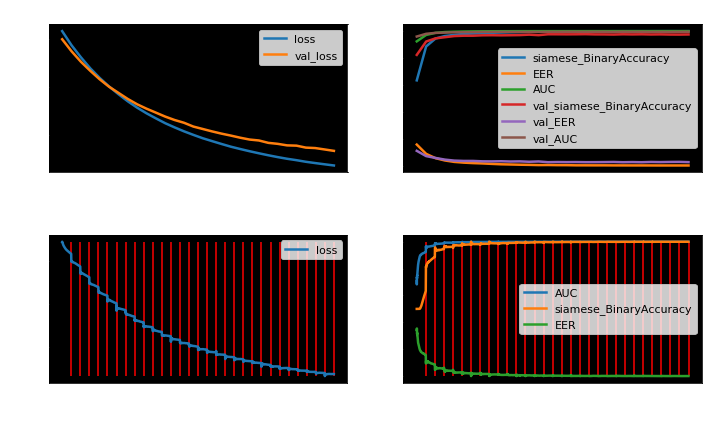

In [4]:
print(model.history)
model.plot_history()

## Embeddings

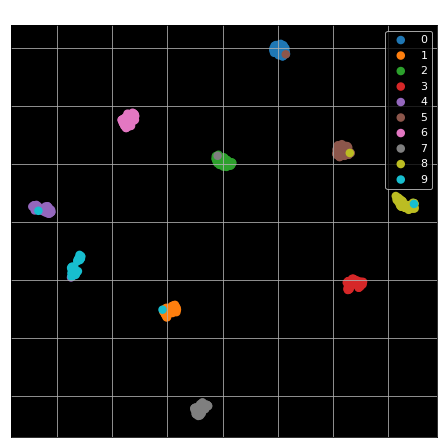

In [4]:
datas = sample_df(valid, n = 10, n_sample = 50)

model.plot_embedding(datas)

## Prediction

### Comparaison

Note : by default the model computes a distance-score and not a similarity score. It means that the score on pictures is the probability to belong to different class. 

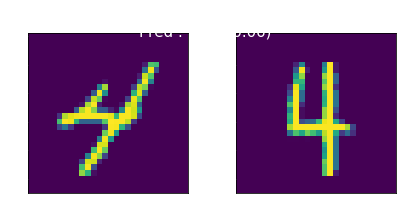

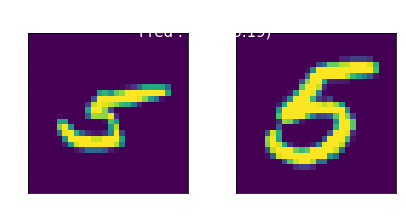

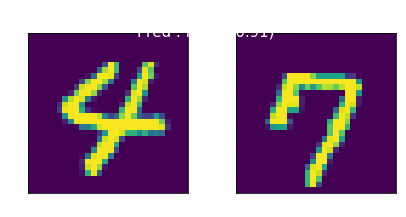

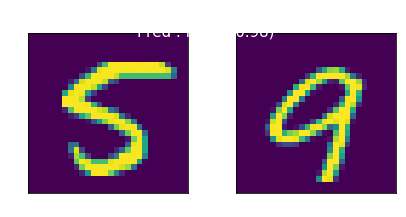

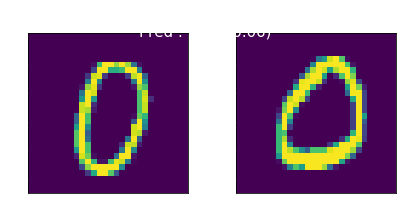

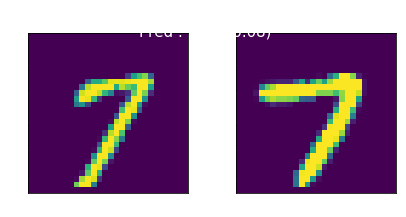

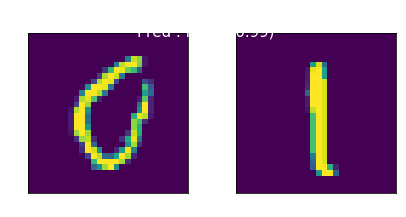

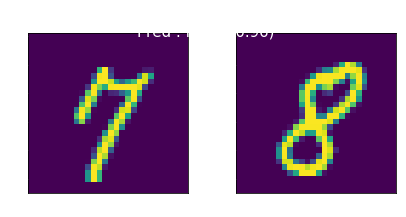

In [5]:
config = model.get_dataset_config(is_validation = True, batch_size = 2)

ds_train = prepare_dataset(train, ** config)

n = 2
for i, (inputs, target) in enumerate(ds_train):
    if i >= n: break
    
    x, y = inputs
    
    scores = tf.squeeze(model(inputs))
    pred = model.decode_output(scores)
    target = model.decode_output(tf.cast(target, tf.float32))
    
    data = {}
    for i, (xi, yi, ti, si, pi) in enumerate(zip(x, y, target, scores, pred)):
        plot_multiple(
            input_x = xi, input_y = yi, plot_type = 'imshow', size = 3,
            title = 'Same : {}\nPred : {} ({:.2f})'.format(ti, pi, float(si))
        )


### Class prediction

The `K-NN` algorithm is used to classify new data based on a set of labelled `samples` (which are the labelled points for the `k-nn`).

Note : the accuracy is **not** representative as you compute it only on 40 test samples (4 for each class) which is far too low. Furthermore,  250 samples of each class are used (i.e. 2500 labelled points) which is a small part of the real training set. This samples-size influences the final prediction (and thus the accuracy)

If you do the test : 
- With `use_mean = True`, I got accuracy between 0.9 and 0.6 depending on `n_saple` and the run (because sampling is random !)
- However, with `k == 7` I got accuracy > 90% for the 5 runs I made !

Note : you can check the `evaluation` section to see the impact of `k`, `use_mean` and `sample_size` while evaluating on the whole validation set : the `accuracy` is not really affected by these parameters (less than 1%)

The big dots are the *centroids*, the small dots are *labelled data* and the *x* are the data to classify. An interesting aspect is that some points are wrongly encoded (the dots with another color than the cluster) but it is not an issue for the classification thanks to the `k` parameter !

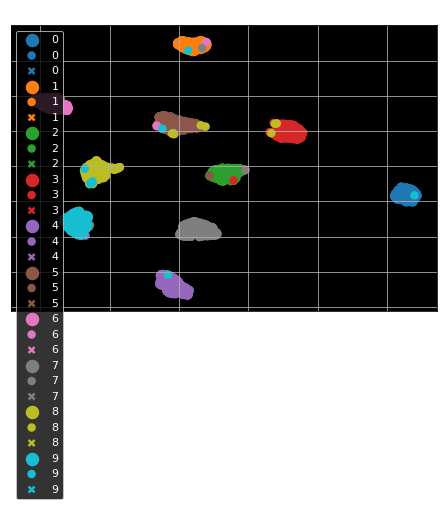

Accuracy : 1.00


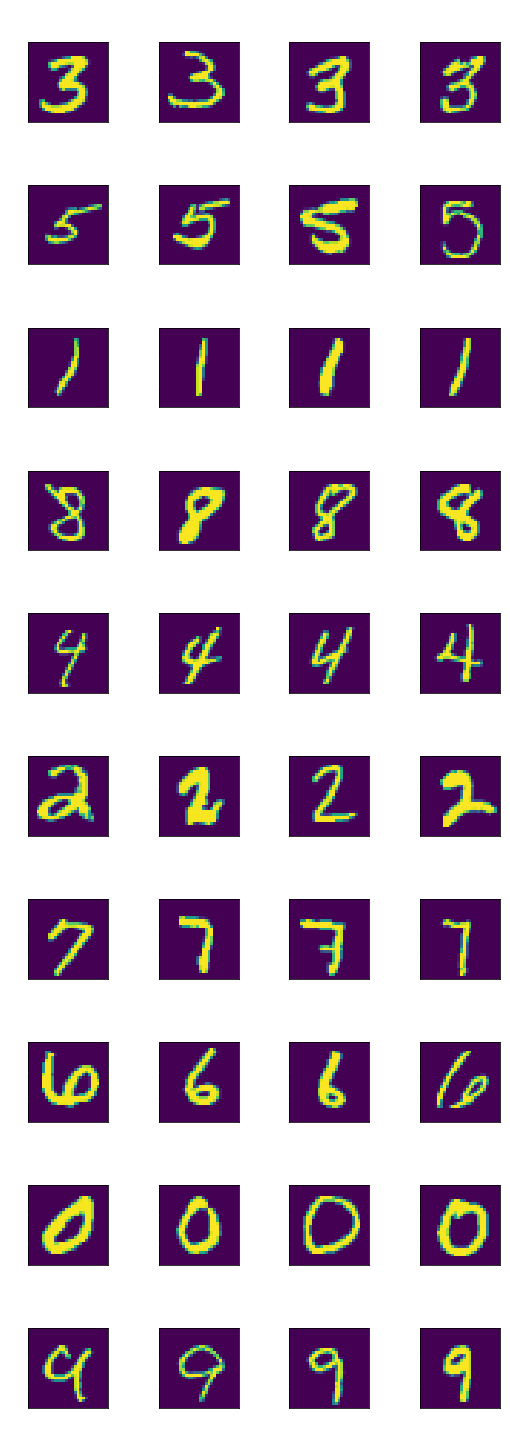

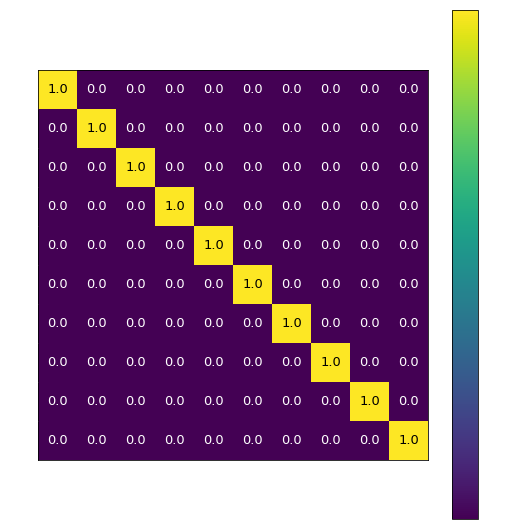

In [4]:
samples = sample_df(train, n = 10, n_sample = 250)
embedded_samples = model.embed(samples)

valid_samples = sample_df(valid, n = 10, n_sample = 4)

ids = valid_samples['id'].values
images = valid_samples['image'].values
pred = model.recognize(
    valid_samples, samples = embedded_samples, ids = samples['id'].values, k = 7, plot = True
)

predictions = {
    'pred_{}'.format(i) : {'x' : images[i], 'title' : 'Class : {}\nPred : {}'.format(id_i, pred_i)}
    for i, (id_i, pred_i) in enumerate(zip(ids, pred))
}

print("Accuracy : {:.2f}".format(np.sum(ids == pred) / len(pred)))

plot_multiple(
    ** predictions, plot_type = 'imshow', ncols = 4, size = 2
)
plot_confusion_matrix(true =  ids, pred = pred)

## Evaluation

Here we will use the evaluation method based on classification : it means we will evaluate this model as a classifier based on the `recognize` method (and not on other evaluation method because... I did not implemented them yet :D )

We will compare the scores for different `k` in the `K-NN` decision rule and try with different `sample_size`

We can see that the impact of these hyperparameters is quite low (less than 1% differences). As we can see on above plots, only 1 or 2 points are clearly in the wrong cluster so using `k-nn` based on mean is not impacted by these outliers and same if we use (at least) 3 or 5 for the `k-nn`

Note that `use_mean` is not impacted by the outliers because we use a large number of points and clusters are far enough. It may be not the case for other applications such as the `AudioSiamese` test where we have small number of datas / ids and much more different ids so I guess outliers can have a bigger impact

An interesting point to note is that the obtained `accuracy` (around 97.5%) is close to the `binary accuracy` computed during training ! This can be useful because it is faster to evaluate, easier to compute and has a better support with the `History` callback (which is note yet supported by the custom `evaluate` method)*

However we **cannot** generalize this property because a counter-example is shown in the `example_fashion_mnist`. However the accuracy for the `fashion_mnist` model is far lower than this one so a first idea could be : the higher the `binary_accuracy`, the higher the `accuracy` and then the lower the differences (but has to be confirmed by experiments) 

*So if you want to evaluate the model based on the classical metrics you can use the `test` method which is equivalent to `train` but only for evaluation procedure

In [4]:
t0 = time.time()
acc = model.evaluate(valid, samples = train, sample_size = 250, k = 5)
print("Accuracy : {:.2f}% (evaluation time : {:.3f} sec)".format(acc * 100, time.time() - t0))

Accuracy : 97.51% (evaluation time : 12.699 sec)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:30<00:00, 12.93s/it]


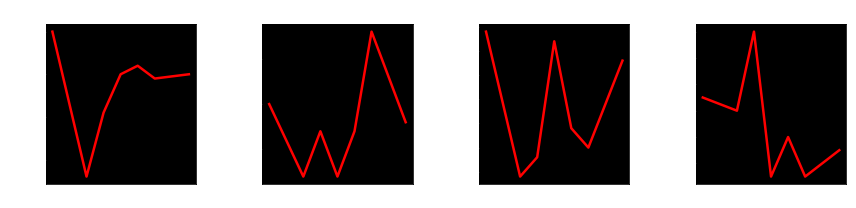

In [5]:
datas = {}
k_values = [-1, 3, 5, 7, 9, 11, 15]
for i, sample_size in enumerate([50, 100, 250, 500]):
    datas['pred_{}'.format(i)] = {
        'x' : k_values,
        'y' : [model.evaluate(
            valid, samples = train, sample_size = sample_size,  k = k, use_mean = k == -1
        ) for k in tqdm(k_values)],
        'title' : '{} samples'.format(sample_size)
    }
plot_multiple(** datas, ncols = 4, size = 3, use_subplots = True)

## Dataset analysis

Here we can see examples of pairs of same / not same labels : **it is the most important part** to be sure datas are well associated and avoid to lose time training on wrong datas !

Original dataset : <ZipDataset shapes: ({id: (), image_x: (28, 28, 1), image_y: (28, 28, 1)}, {id_x: (), id_y: (), image_x: (28, 28, 1), image_y: (28, 28, 1)}), types: ({id: tf.int32, image_x: tf.uint8, image_y: tf.uint8}, {id_x: tf.int32, id_y: tf.int32, image_x: tf.uint8, image_y: tf.uint8})>
- Dataset after encoding : <ParallelMapDataset shapes: ((((28, 28, 1), (28, 28, 1)), ()), (((28, 28, 1), (28, 28, 1)), ())), types: (((tf.float32, tf.float32), tf.int32), ((tf.float32, tf.float32), tf.int32))>
- Dataset after filtering : <FilterDataset shapes: ((((28, 28, 1), (28, 28, 1)), ()), (((28, 28, 1), (28, 28, 1)), ())), types: (((tf.float32, tf.float32), tf.int32), ((tf.float32, tf.float32), tf.int32))>
- Dataset after augmentation : <ParallelMapDataset shapes: ((((28, 28, 1), (28, 28, 1)), ()), (((28, 28, 1), (28, 28, 1)), ())), types: (((tf.float32, tf.float32), tf.int32), ((tf.float32, tf.float32), tf.int32))>
- Dataset after batch : <BatchDataset shapes: ((((None, 28, 28, 1), (None,

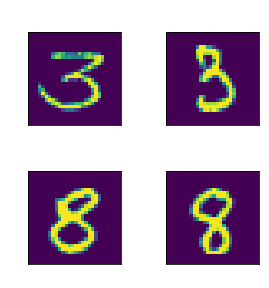

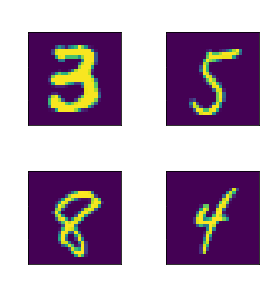

tf.Tensor([0 0 1 1], shape=(4,), dtype=int32)


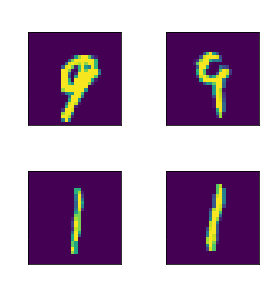

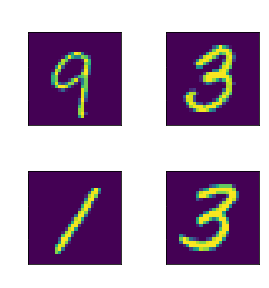

In [6]:
config = model.get_dataset_config(is_validation = False, batch_size = 2)

ds_train = prepare_dataset(train, ** config)

n = 2
for i, (inputs, target) in enumerate(ds_train):
    if i >= n: break
    
    (x, y) = inputs
    
    print(target)
    sames, not_sames = {}, {}
    for i, (xi, yi) in enumerate(zip(x, y)):
        if i < len(x) // 2:
            sames.update({
                'x_{}'.format(i) : xi,
                'y_{}'.format(i) : yi
            })
        else:
            not_sames.update({
                'x_{}'.format(i) : xi,
                'y_{}'.format(i) : yi
            })
    
    plot_multiple(
        title = 'Same pairs', ** sames, plot_type = 'imshow', size = 2
    )
    plot_multiple(
        title = 'Not same pairs', ** not_sames, plot_type = 'imshow', size = 2
    )
